# **Messi outlier**
## Assists

The aim of this notebook is to assess whether Messi’s assists performance can be considered an outlier when compared to other top goalscorers.
An assist refers to a pass that directly sets up a teammate to score a goal.

### Datasets
We use `dataset2_player_performances.parquet` & `dataset2_player_profiles`

- `dataset2_player_performances.parquet`: provides football player performances
- `dataset2_player_profiles`: provides football player names and other personal attributes

We merge the performance and profiles dataset using player_id as link

**Resulting dataset: `merged_player_data.parquet`**

In [2]:
import pandas as pd

# Load datasets (go up one level from notebooks/ to reach data/)
df_perf = pd.read_parquet("../data/dataset2_player_performances.parquet")
df_profiles = pd.read_parquet("../data/dataset2_player_profiles.parquet")

# Merge on player_id
df_merged = df_perf.merge(df_profiles, on="player_id", how="left")

# Save the merged dataset back into data/ or notebooks/
df_merged.to_parquet("../data/merged_player_data.parquet", index=False)

### We now focus on `assists` variable

In [4]:
import pandas as pd

# Load merged dataset
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

# Aggregate total assists per player and sort
top_assisters = (
    df_merged.groupby("player_name", as_index=False)["assists"]
    .sum()
    .sort_values("assists", ascending=False)
)

# Shape of the aggregated data
print("Shape (rows, columns):", top_assisters.shape)

# Show the first rows
top_assisters.head(20)

Shape (rows, columns): (87891, 2)


,player_name,assists
47961,Lionel Messi (28003),368
79594,Thomas Müller (58358),281
87298,Ángel Di María (45320),278
50157,Luis Suárez (44352),277
72706,Ryan Giggs (3406),269
21443,Dušan Tadić (36139),267
44829,Kevin De Bruyne (88755),261
15601,Cristiano Ronaldo (8198),257
33900,Hulk (80562),231
62088,Neymar (68290),227


## Building the Assists Viz

### 1) Data prep chunk

In [5]:
import numpy as np
import pandas as pd

# --- Load & basic hygiene ---
df_merged = pd.read_parquet("../data/merged_player_data.parquet").copy()
# Ensure assists/goals are numeric (robust to weird types)
for col in ["assists", "goals"]:
    if col in df_merged.columns:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)

# --- Load & aggregate (career totals per player) ---
agg_all = (
    df_merged.groupby("player_name", as_index=False)[["assists", "goals"]]
             .sum()
             .rename(columns={"assists": "value"})   # <-- rank by ASSISTS now
)
agg_all["ga_total"] = agg_all["value"] + agg_all["goals"]  # total (assists + goals), optional
agg_assists = agg_all[agg_all["value"] > 0].copy()         # Players with ≥1 assist

# --- Find Messi (handles optional id suffix like " (28003)") ---
m = agg_all["player_name"].str.contains(r"^Lionel Messi(?:\s*\(\d+\))?$",
                                        case=False, na=False)
messi_name = agg_all.loc[m, "player_name"].iloc[0] if m.any() else None

# --- Cohorts: Top-N assisters across ALL players ---
def topN_assisters(df_agg: pd.DataFrame, N: int) -> pd.DataFrame:
    top_names = set(df_agg.sort_values("value", ascending=False).head(N)["player_name"])
    if messi_name is not None:
        top_names.add(messi_name)  # force-include Messi
    return df_agg[df_agg["player_name"].isin(top_names)].copy()

agg_top1000 = topN_assisters(agg_all, 1000)
agg_top500  = topN_assisters(agg_all, 500)
agg_top100  = topN_assisters(agg_all, 100)
agg_top10   = topN_assisters(agg_all, 10)

# --- Build combined DF with row labels (for plotting/faceting) ---
def prep_block(df: pd.DataFrame, row_label: str) -> pd.DataFrame:
    out = df.loc[:, ["player_name", "value"]].copy()  # 'value' = total assists
    out["row"] = row_label
    out["is_messi"] = (out["player_name"] == messi_name)
    return out

df_plot = pd.concat(
    [
        prep_block(agg_assists, "All assisters"),
        prep_block(agg_top1000, "Top-1000 assisters"),
        prep_block(agg_top500,  "Top-500 assisters"),
        prep_block(agg_top100,  "Top-100 assisters"),
        prep_block(agg_top10,   "Top-10 assisters"),
    ],
    ignore_index=True
)

# --- Jitter column for background dots (ONLY for plotting) ---
rng = np.random.default_rng(123)
mask_other = ~df_plot["is_messi"]
df_plot.loc[mask_other, "value_jit"] = (
    df_plot.loc[mask_other, "value"] + rng.uniform(-0.3, 0.3, mask_other.sum())
)
df_plot.loc[~mask_other, "value_jit"] = df_plot.loc[~mask_other, "value"]

# --- Quick peek: Top 1000 assisters table (optional) ---
top1000_assisters = agg_top1000.sort_values("value", ascending=False).reset_index(drop=True)
top1000_assisters.head(20)

,player_name,value,goals,ga_total
0,Lionel Messi (28003),368,771.0,1139.0
1,Thomas Müller (58358),281,293.0,574.0
2,Ángel Di María (45320),278,200.0,478.0
3,Luis Suárez (44352),277,509.0,786.0
4,Ryan Giggs (3406),269,168.0,437.0
5,Dušan Tadić (36139),267,232.0,499.0
6,Kevin De Bruyne (88755),261,156.0,417.0
7,Cristiano Ronaldo (8198),257,796.0,1053.0
8,Hulk (80562),231,434.0,665.0
9,Neymar (68290),227,366.0,593.0


### 2) Viz chunk

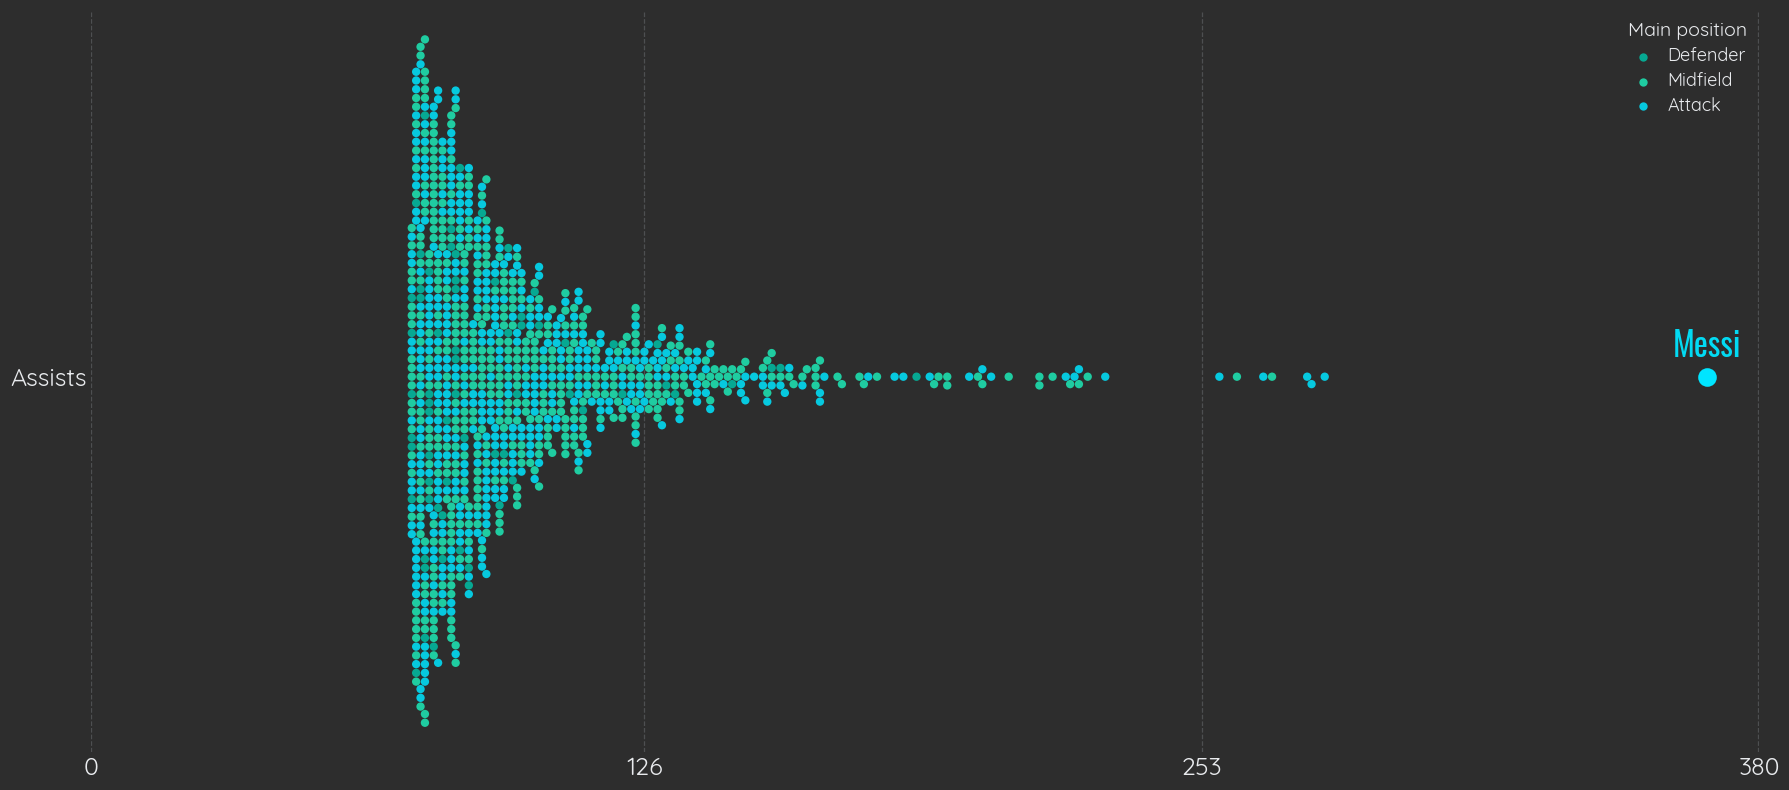

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import re
from collections import Counter

# Optional fonts
from pyfonts import load_font
oswald = load_font("https://github.com/google/fonts/raw/main/ofl/oswald/Oswald%5Bwght%5D.ttf")
quick_reg = load_font("/Users/andresdevegili/Documents/fonts/Quicksand/static/Quicksand-Regular.ttf")

# ---------------------------
# Params
# ---------------------------
TOP_N = 1000
ASSISTS_MIN = 1
XMAX_HARD_CAP = 400     # set None to let data decide
XMIN = 0

# ---------------------------
# Load & prepare
# ---------------------------
df_merged = pd.read_parquet("../data/merged_player_data.parquet").copy()

# Ensure numeric
for col in ["goals", "assists"]:
    if col in df_merged.columns:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)

# Normalize main_position
df_merged["main_position"] = (
    df_merged["main_position"]
      .astype(str)
      .str.strip()
      .str.title()
)

# Per-player mode of main_position
def mode_or_first(series: pd.Series) -> str:
    vals = [v for v in series.dropna().tolist() if v != ""]
    if not vals: return "Unknown"
    return Counter(vals).most_common(1)[0][0]

pos_per_player = (
    df_merged.groupby("player_name", as_index=False)["main_position"]
             .agg(mode_or_first)
             .rename(columns={"main_position": "main_position_mode"})
)

# Aggregate career totals
agg = (
    df_merged.groupby("player_name", as_index=False)[["goals", "assists"]].sum()
    .merge(pos_per_player, on="player_name", how="left")
)
agg["ga_total"] = agg["goals"] + agg["assists"]
agg = agg[agg["assists"] >= ASSISTS_MIN].copy()

# Find Messi
messi_pat = re.compile(r"^Lionel Messi(?:\s*\(\d+\))?$", re.IGNORECASE)
messi_rows = agg[agg["player_name"].str.contains(messi_pat, na=False)]
messi_name = messi_rows["player_name"].iloc[0] if not messi_rows.empty else None

# Top-N by assists (+ include Messi)
top_players = set(agg.sort_values("assists", ascending=False).head(TOP_N)["player_name"])
if messi_name is not None:
    top_players.add(messi_name)

# Plot DF
df_ass = (
    agg[agg["player_name"].isin(top_players)]
    .loc[:, ["player_name", "assists", "main_position_mode"]]
    .rename(columns={"assists": "value", "main_position_mode": "main_position"})
)
df_ass["metric"] = "Assists"
df_ass["is_messi"] = (df_ass["player_name"] == messi_name)

# ---------------------------
# Improved cyan–greenish palette (dark bg)
# ---------------------------
ATTACK_CYAN   = "#00E5FF"  # vivid cyan (bright, blue-leaning)
MID_AQUA      = "#1DE9B6"  # bright aqua-green (shifted toward green, clearly distinct)
DEF_TEAL      = "#00BFA5"  # medium teal (darker, less saturated)
GK_LIME       = "#AEEA00"  # lime-green (contrasting pop for GK)
UNK_GRAY      = "#9AA0A6"  # neutral gray

pos_order = ["Goalkeeper", "Defender", "Midfield", "Attack", "Unknown"]
present = [p for p in pos_order if p in df_ass["main_position"].unique().tolist()]

palette_map_full = {
    "Attack":      ATTACK_CYAN,
    "Midfield":    MID_AQUA,
    "Defender":    DEF_TEAL,
    "Goalkeeper":  GK_LIME,
    "Unknown":     UNK_GRAY,
}
palette_map = {p: palette_map_full[p] for p in present}
hue_order = present

# Messi uses the Attack cyan
messi_color = ATTACK_CYAN

# ---------------------------
# Axis range
# ---------------------------
if not df_ass.empty:
    vmax = df_ass["value"].max()
    p99 = np.percentile(df_ass["value"], 99) if len(df_ass) > 1 else vmax
    right = max(vmax, p99 * 1.05)
else:
    right = 200
if XMAX_HARD_CAP is not None:
    right = min(right, XMAX_HARD_CAP)
right = int(np.ceil(right / 20.0) * 20)

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(18, 8))

# Apply dark background (#2d2d2d / 1.0)
fig.patch.set_facecolor("#2d2d2d")
ax.set_facecolor("#2d2d2d")

# Beeswarm by position
sns.swarmplot(
    data=df_ass[~df_ass["is_messi"]],
    x="value", y="metric",
    order=["Assists"],
    hue="main_position",
    hue_order=hue_order,
    palette=palette_map,
    size=6, alpha=0.85, dodge=False, ax=ax
)

# Messi overlay in Attack color
messi_pts = df_ass[df_ass["is_messi"]]
if not messi_pts.empty:
    ax.scatter(
        messi_pts["value"], messi_pts["metric"],
        s=180, c=[messi_color], zorder=3, linewidths=0
    )
    for x in messi_pts["value"]:
        ax.annotate(
            "Messi",
            xy=(x, "Assists"),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center", va="bottom",
            color=messi_color, fontsize=24,
            fontproperties=oswald, alpha=0.95,
            clip_on=False
        )

# Axes & grid (light guides on dark bg)
ax.set_xlim(XMIN, right)
ax.set_xlabel(""); ax.set_ylabel(""); ax.set_title("")
ticks = np.linspace(max(XMIN, 0), right, 4, dtype=int).tolist()
ax.set_xticks(ticks)

xmin, xmax = ax.get_xlim(); eps = (xmax - xmin) * 1e-3
for xpos in ticks:
    xx = xpos - eps if np.isclose(xpos, xmax) else xpos
    ax.axvline(xx, color="#9aa0a6", alpha=0.3, linestyle="--", linewidth=0.9, zorder=0)

ax.set_yticks([0]); ax.set_yticklabels(["Assists"])

# Legend (light text on dark bg)
leg = ax.legend(title="Main position", loc="upper right", frameon=False, ncol=1)
if leg:
    for text in leg.get_texts():
        text.set_fontproperties(quick_reg); text.set_fontsize(13); text.set_color("#e8eaed")
    if leg.get_title():
        leg.get_title().set_fontproperties(quick_reg); leg.get_title().set_fontsize(14); leg.get_title().set_color("#e8eaed")

# Typography & clean look for dark bg
for lab in ax.get_xticklabels() + ax.get_yticklabels():
    lab.set_fontproperties(quick_reg); lab.set_fontsize(18); lab.set_color("#e8eaed")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=True, labelbottom=True, length=0)

plt.tight_layout()
# plt.savefig("../figs/top1000_assists_by_position_dark.png", dpi=240, facecolor=fig.get_facecolor(), bbox_inches="tight")
plt.show()